***

# Homework 4

**Course:** MATH 616 - Data-Driven Dynamical Systems, Stochastic Modeling and Prediction

**Name:** Shrivats Sudhir

**NetID:** ssudhir2

**Email:** ssudhir2@wisc.edu

***

In [29]:
import numpy as np
import matplotlib.pyplot as plt

# Question 1.

**Consider the following linear Gaussian model:**

$$d\;x(t) = [-a \cdot x(t) + f]\;dt + \sigma_{x}\;dW_{x}(t)$$

## (a.)

**Write down a general code for Kalman filter and show the numerical results with $a = f = \sigma_{x} = 1$, the observational time step $\Delta t = 0.4$ and the observational noise level $\sigma_0 = 0.5$.**

**You may consider a time series with the total length $T = 500$.**

The following solution is inspired by 10.1.2 from the lecture notes.

The exact path-wise solution from $t_m$ to $t_{m+1}$ can be expressed explicitly:
\begin{equation*}
    \begin{split}
        x(t_{m+1}) &= \underbrace{x(t_m) \cdot \text{exp}(-a \cdot \Delta t)}_{\text{Deterministic Decay of } x(t_m): A_m x(t_m) }\\
        \\
        & \quad - \underbrace{\frac{f}{a} \cdot (1 - \text{exp}(-a \cdot \Delta t))}_{\text{Forcing Term: } F_m }\\
        \\
        & \quad + \underbrace{\sigma_x \cdot \int_{t_{m+1}}^{t_{m}} \text{exp}(-a \cdot (t_{m+1} - s))\; dW(s)}_{\text{Stochastic Term: } \sigma_m }
    \end{split}
\end{equation*}

For the stochastic term, we can use Monte Carlo Simulations as follows:
$$\int_{t_{m+1}}^{t_{m}} \text{exp}(-a \cdot (t_{m+1} - s))\; dW(s) \approx \sum_{i=1}^{N} \text{exp}(-a \cdot (t_{m+1} - t_i)) \cdot \Delta W_i $$
where $\Delta W_i \sim N(0, \sqrt{ \Delta t / N })$

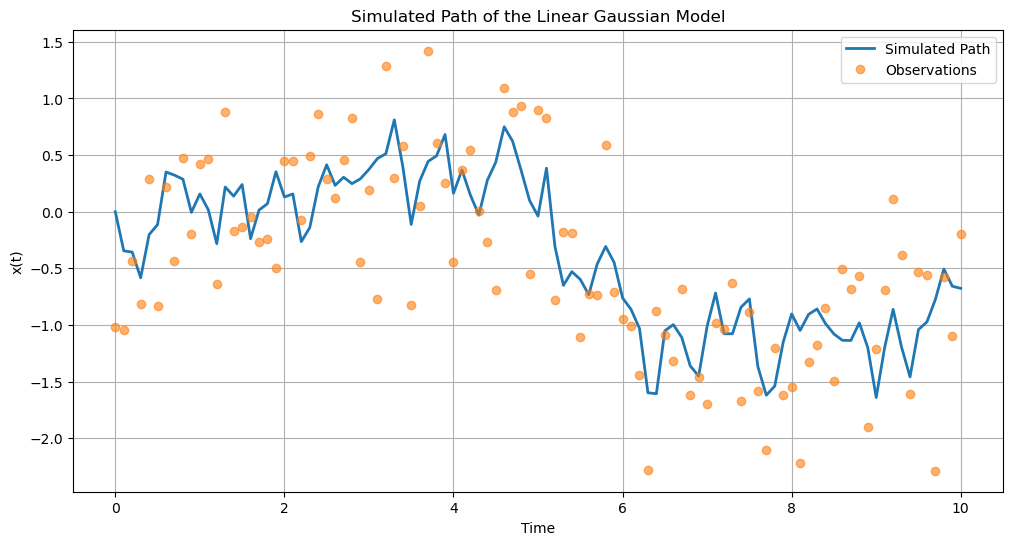

In [30]:
def approximate_stochastic_term(a, delta_t, N):
    """
    Approximates the stochastic integral term in the SDE using Monte Carlo.

    Parameters:
        a (float): Drift coefficient in the SDE.
        delta_t (float): Time step size (t_{m+1} - t_m).
        N (int): Number of sub-intervals for numerical approximation.

    Returns:
        float: Approximation of the stochastic term.
    """
    # Discretize the time interval
    t = np.linspace(0, delta_t, N + 1)  # Subdivision times
    dW = np.random.normal(0, np.sqrt(delta_t / N), size=N)  # Wiener increments

    # Compute the stochastic integral
    stochastic_term = 0
    for i in range(N):
        exp_factor = np.exp(-a * (delta_t - t[i]))  # Exponential decay factor
        stochastic_term += exp_factor * dW[i]      # Accumulate contributions

    return stochastic_term


def simulate_exact_path(x0, a, f, sigma_x, delta_t, T):
    """
    Simulates the exact path of the linear SDE model.

    The SDE is of the form:
        dx(t) = [-a * x(t) + f] * dt + sigma_x * dW(t)

    Parameters:
        x0 (float): Initial state of the system.
        a (float): Drift coefficient in the SDE.
        f (float): Forcing term.
        sigma_x (float): Diffusion coefficient (noise intensity).
        delta_t (float): Time step size.
        T (float): Total simulation time.

    Returns:
        numpy.ndarray: Simulated path of the system over time.
    """
    # Number of time steps
    N = int(T / delta_t)

    # Initialize the solution array
    x = np.zeros(N + 1)

    # Set initial condition
    x[0] = x0

    # Simulate over the time grid
    for t in range(N):
        decay = x[t] * np.exp(-a * delta_t)  # Deterministic decay
        forcing = -f / a * (1 - np.exp(-a * delta_t))  # Forcing term
        stochastic = sigma_x * approximate_stochastic_term(a, delta_t, N=100)  # Stochastic term

        # Update the state
        x[t + 1] = decay + forcing + stochastic

    return x

# Simulation parameters
x0 = 0.0               # Initial state
a = 1.0                # Drift coefficient
f = 1.0                # Forcing term
sigma_x = 1.0          # Diffusion coefficient
sigma_0 = 0.5          # Observation Noise SD
delta_t = 0.1          # Time step size
T = 10                 # Total simulation time
N = int(T / delta_t)   # Number of time steps

# Generate time grid
time = np.linspace(0, T, N + 1)

# Simulate the path
true_path = simulate_exact_path(x0, a, f, sigma_x, delta_t, T)

# Simulated noisy observations
observations = true_path + np.random.normal(0, sigma_0, size=N + 1)

# Plot the simulated path
plt.figure(figsize=(12, 6))
plt.plot(time, true_path, label="Simulated Path", linewidth=2)
plt.plot(time, observations, 'o', label="Observations", alpha=0.6)
plt.title("Simulated Path of the Linear Gaussian Model")
plt.xlabel("Time")
plt.ylabel("x(t)")
plt.legend()
plt.grid()
plt.show()

Now, by 10.1.1, we know that the prior distribution is:
\begin{equation*}
    \begin{split}
        \bar{x}_{m+1|m} &= A_m \bar{x}_{m|m} + F_m\\
                        &= \bar{x}(t_m) \cdot \text{exp}(-a \cdot \Delta t)\\
                        & \quad + f/a \cdot (1 - \text{exp}(-a \cdot \Delta t))
    \end{split}
\end{equation*}

\begin{equation*}
    \begin{split}
        r_{m+1|m} &= A^2_m r_{m|m} + r\\
                  &= \text{exp}(-2a \cdot \Delta t) r_{m|m} + r
    \end{split}
\end{equation*}

In [31]:
def prior_parameters(prior_x, prior_r, f, a, delta_t, r):
    """
    Computes the prior mean and variance based on the given equations.

    Parameters:
        x_prior (float): The posterior mean from the previous step (x_{m|m}).
        r_prior (float): The posterior variance from the previous step (r_{m|m}).
        a (float): Drift coefficient in the SDE.
        f (float): Forcing term.
        delta_t (float): Observational time step size.
        r(float): Process noise variance (sigma_x^2).
    
    Returns:
        tuple: (updated_mean, updated_variance)
    """
    A_m = np.exp(-a * delta_t)
    F_m = f/a * (1 - np.exp(-a * delta_t))

    return A_m * prior_x + F_m, A_m**2 * prior_r + r

# Input parameters
x_prior = 0.0           # Initial posterior mean
r_prior = 0.0           # Initial posterior variance
a = 1.0                 # Drift coefficient
f = 1.0                 # Forcing term
delta_t = 0.4           # Observational time step size
sigma_x = 1.0           # Process noise standard deviation
r_process = sigma_x**2  # Process noise variance

# Compute prior mean and variance
prior_mean, prior_r = prior_parameters(x_prior, r_prior, a, f, delta_t, r_process)
print("prior mean:", prior_mean)
print("prior variance:", prior_r)

prior mean: 0.3296799539643608
prior variance: 1.0


The Kalman gain is:
$$K_{m+1} = \frac{r_{m+1|m}}{r^0 + r_{m+1|m}}$$

The posterior mean and variance can be computed as:
\begin{equation*}
    \begin{split}
        \bar{x}_{m+1|m+1} &= (1 - K_{m+1}) \cdot \bar{x}_{m+1|m} + v_{m+1} \cdot K_{m+1}
    \end{split}
\end{equation*}

\begin{equation*}
    \begin{split}
        r_{m+1|m} &= (1 - K_{m+1}) \cdot r_{m+1 | m}
    \end{split}
\end{equation*}

In [32]:
def kalman_update(prior_mean, prior_r, v_obs, r_obs):
    """
    Computes the posterior mean and variance using the Kalman filter equations.
    
    Parameters:
        mean_prior (float): Prior mean (x_{m+1|m}).
        r_prior (float): Prior variance (r_{m+1|m}).
        z_obs (float): Observed value (z_{m+1}).
        r_obs (float): Observation noise variance (r^0).
    
    Returns:
        tuple: (posterior_mean, posterior_variance, kalman_gain)
    """

    # Computing Kalman Gain
    kalman_update = prior_r / (prior_r + r_obs) if (r_prior + r_obs) != 0 else 0

    # Update posterior mean
    posterior_mean = prior_mean + kalman_update * (v_obs - prior_mean)

    # Update posterior variance
    posterior_variance = (1 - kalman_update) * prior_r

    return (posterior_mean, posterior_variance, kalman_update)

# Example usage
v_obs = 1.0              # Example observation
r_obs = sigma_x**2       # Observation noise variance

(posterior_mean, posterior_variance, kalman_g) = kalman_update(prior_mean, prior_r, v_obs, r_obs)
print("Kalman Gain:", kalman_g)
print("Posterior Mean:", posterior_mean)
print("Posterior Variance:", posterior_variance)

Kalman Gain: 0.5
Posterior Mean: 0.6648399769821804
Posterior Variance: 0.5


Finally, putting it all together, we have:

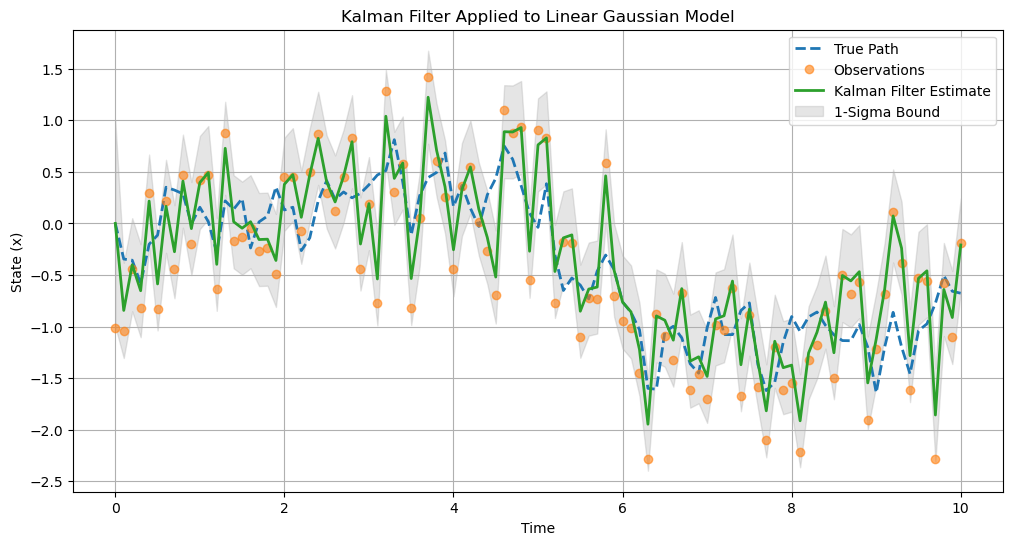

In [33]:
# Complete the Kalman filter loop implementation
kalman_means = np.zeros(N+1)      # Store Kalman filter means
kalman_variance = np.zeros(N+1)   # Store Kalman filter variances

# Initialize with prior values
kalman_means[0] = 0.0     # Initial mean
kalman_variance[0] = 1.0  # Initial variance

for t in range(1, N+1):

    # Compute prior parameters
    prior_mean, prior_r = prior_parameters(
        kalman_means[t - 1], kalman_variance[t - 1],
        a, f, delta_t, sigma_x**2
    )

    # Update with observation
    posterior_mean, posterior_variance, kalman_gain = kalman_update(
        prior_mean, prior_r, observations[t], sigma_0**2
    )

    # Store updated values
    kalman_means[t] = posterior_mean
    kalman_variance[t] = posterior_variance

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(time, true_path, 
         label="True Path", linewidth=2, linestyle='--')
plt.plot(time, observations, 'o', 
         label="Observations", alpha=0.6)
plt.plot(time, kalman_means, 
         label="Kalman Filter Estimate", linewidth=2)

plt.fill_between(time, 
                 kalman_means - np.sqrt(kalman_variance),
                 kalman_means + np.sqrt(kalman_variance), 
                 color='gray', alpha=0.2, label="1-Sigma Bound")

plt.title("Kalman Filter Applied to Linear Gaussian Model")
plt.xlabel("Time")
plt.ylabel("State (x)")
plt.legend()
plt.grid()
plt.show()

## (b.)

**Show the root-mean-square error (RMSE) in the posterior mean as a function of $\sigma_0$ (keep other parameters the same as above). You may consider a time series with the total length $T=500$ and compute the RMSE from the period from $t=50$ to $500$.**

[0.859033781597324, 0.9329933738178376, 1.879929923637202, 1.001404762074894, 1.8300121091579395, 1.7417766965846933, 1.9845934271117576, 1.386214340359425, 2.4998167813802836, 1.6944815076015487, 1.9998063575377245, 2.2292763744751487, 2.0335498951731172, 2.096580441076865, 1.76424708105552, 1.8469325739042664, 1.1852619326690639, 1.9694163549361912, 1.903416599848021, 2.1757597156508344]


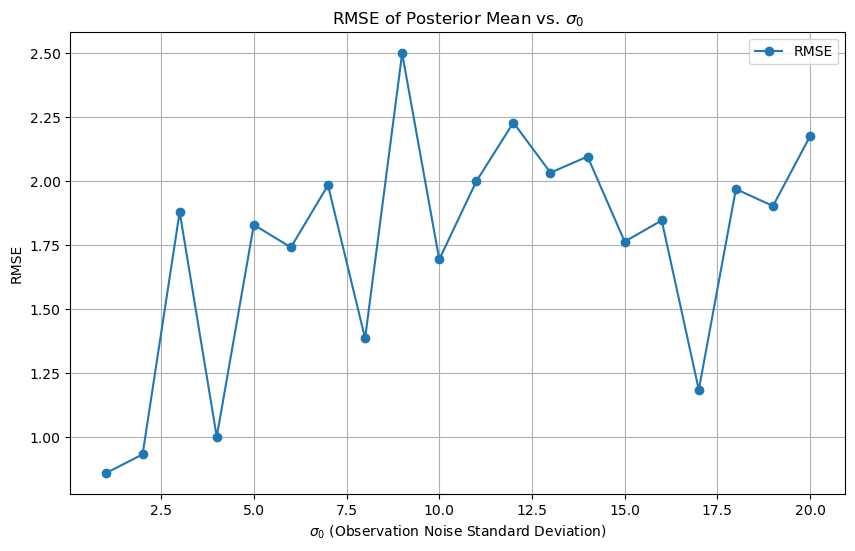

In [34]:
def compute_rmse(sigma_0, M):
    # Recalculate N for consistency
    N = int(T / delta_t)
    
    # Simulate the path
    true_path = simulate_exact_path(x0, a, f, sigma_x, delta_t, T)

    # Simulated noisy observations
    observations = true_path + np.random.normal(0, sigma_0, size=N + 1)

    # Initialize Kalman filter variables
    kalman_means = np.zeros(N + 1)
    kalman_variances = np.zeros(N + 1)

    kalman_means[0] = 0.0       # Initial posterior mean
    kalman_variances[0] = 1.0   # Initial posterior variance

    for t in range(1, N+1):
        # Compute prior parameters
        prior_mean, prior_r = prior_parameters(
            kalman_means[t-1], kalman_variances[t-1],
            a, f, delta_t, sigma_x**2
        )

        # Update with observation
        posterior_mean, posterior_variance, kalman_gain = kalman_update(
            prior_mean, prior_r, observations[t], sigma_0**2
        )

        # Store updated values
        kalman_means[t] = posterior_mean
        kalman_variances[t] = posterior_variance

    return np.sqrt(np.mean((true_path[M:] - kalman_means[M:])**2))

# Range of sigma_0 values to test
sigma_obs_values = np.linspace(1, 20, 20)
rmse_values = [compute_rmse(sigma_obs, M=5) for sigma_obs in sigma_obs_values]
print(rmse_values)

# Plot RMSE as a function of sigma_0
plt.figure(figsize=(10, 6))
plt.plot(sigma_obs_values, 
         rmse_values, marker='o', label="RMSE")
plt.title("RMSE of Posterior Mean vs. $\\sigma_0$")
plt.xlabel("$\\sigma_0$ (Observation Noise Standard Deviation)")
plt.ylabel("RMSE")
plt.grid()
plt.legend()
plt.show()